# Compile the main simulator code using cython 

In [1]:
!python setup.py build_ext --inplace

Compiling agent_timestep_plasticity.pyx because it changed.
[1/1] Cythonizing agent_timestep_plasticity.pyx
running build_ext
building 'agent_timestep_plasticity' extension
creating build
creating build\temp.win-amd64-cpython-311
creating build\temp.win-amd64-cpython-311\Release
"C:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -IC:\Users\mclapp\anaconda3\envs\cbgtpy_env2\include -IC:\Users\mclapp\anaconda3\envs\cbgtpy_env2\Include "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\um" "-IC:\Program Files (x86)\Windows Kits\10\include\1

C:\Users\mclapp\anaconda3\envs\cbgtpy_env2\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\agent_timestep_plasticity.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\mclapp\anaconda3\envs\cbgtpy_env2\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\agent_timestep_stop_signal.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


# Import all the relevant files 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import seaborn as sns
import pathos.multiprocessing

In [20]:
#Importing scripts:

#Import relevant frames:
import cbgt as cbgt
import pipeline_creation as pl_creat

#Import plotting functions:
import plotting_functions as plt_func
import plotting_helper_functions as plt_help
import postprocessing_helpers as post_help

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload 

import warnings
warnings.simplefilter('ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Choose the experiment and create the main pipeline

Choose the experiment to run, and define the number of choices, the number of simulations/thread to run and number of cores:

In [4]:
#Choose the experiment:
experiment_choice = 'stop-signal'

if experiment_choice == 'stop-signal':
    import paramfile_stopsignal as paramfile
elif experiment_choice == 'n-choice':
    import paramfile_nchoice as paramfile

number_of_choices = 2
num_sims = 1
num_cores = 7


#Call choose_pipeline with the pipeline object:
pl_creat.choose_pipeline(experiment_choice)
#Create the main pipeline:
pl = pl_creat.create_main_pipeline(runloop=True)

#Set a seed:
seed = np.random.randint(0,99999999,1)[0]
print(seed)

in choose pipeline
in reward pipeline
75434668


Define data and figures directories:

In [5]:
data_dir = "./Data/"
figure_dir = "./Figures/"

# Modify cellular parameters as desired. 
### The paramfile has all the parameter dictionaries that can be modified. They are listed as below:
- celldefaults (neuronal parameters)
- d1defaults (dSPN parameters)
- d2defaults (iSPN parameters)
- dpmndefaults (dopamine related parameters)
- basestim (background input for the nuclei)
- popspecific (population specific parameters)
- receptordefaults (GABA, AMPA receptor parameters)
### The details of each of these dictionaries can be checked by simply typing paramfile.<parameter name> as also shown in the block below

In [26]:
# list out the available parameter dictionaries
dir(paramfile)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'basestim',
 'celldefaults',
 'd1defaults',
 'd2defaults',
 'dpmndefaults',
 'np',
 'pd',
 'popspecific',
 'receptordefaults']

In [28]:
# view (or edit) one of the parameter dictionaries
paramfile.celldefaults

{'N': [75],
 'C': [0.5],
 'Taum': [20],
 'RestPot': [-70],
 'ResetPot': [-55],
 'Threshold': [-50],
 'RestPot_ca': [-85],
 'Alpha_ca': [0.5],
 'Tau_ca': [80],
 'Eff_ca': [0.0],
 'tauhm': [20],
 'tauhp': [100],
 'V_h': [-60],
 'V_T': [120],
 'g_T': [0],
 'g_adr_max': [0],
 'Vadr_h': [-100],
 'Vadr_s': [10],
 'ADRRevPot': [-90],
 'g_k_max': [0],
 'Vk_h': [-34],
 'Vk_s': [6.5],
 'tau_k_max': [8],
 'n_k': [0],
 'h': [1]}

In [ ]:
### To change a parameter, simply assign the desired value to the parameter
### eg. paramfile.celldefaults['C'] = 0.5

# Running the pipeline

### Define configuration parameter

In [7]:
configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None,
    'thalamic_threshold': 30.,
    'movement_time': ['mean', 250], #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout': 300,
    
    'params': paramfile.celldefaults,  #neuron parameters
    'pops': paramfile.popspecific,    #population parameters
    'receps' : paramfile.receptordefaults, #receptor parameters
    'base' : paramfile.basestim,   #baseline stimulation parameters
    'dpmns' : paramfile.dpmndefaults,  #dopamine related parameters
    'd1' : paramfile.d1defaults,     #dSPNs population related parameters
    'd2' : paramfile.d2defaults,     #iSPNs population related parameters
    'channels' : pd.DataFrame([['left'], ['right']], columns=['action']), #action channels related parameters
    'number_of_choices': number_of_choices,
    'newpathways' : None,     #connectivity parameters
    'Q_support_params': None, #initialization of Q-values update
    'Q_df_set': pd.DataFrame([[0.5, 0.5]],columns=["left", "right"]), #initialized Q-values df  
    'n_trials': 1,            #number of trials
    'volatility': [None,"exact"], #frequency of changepoints
    'conflict': (1.0, 0),         #probability of the preferred choice
    'reward_mu': 1,               #mean for the magnitude of the reward
    'reward_std': 0.1,            #std for the magnitude of the reward
    'maxstim': 0.8,               #amplitude of the cortical input over base line
    'sustainedfraction': 0.75,
    
    #Stop 1
    'stop_signal_present': [True,True],
    'stop_signal_probability': [1., 1.],  #probability of trials that will get the stop-signal / list of trial numbers
    'stop_signal_amplitude': [0.6, 0.6],  #amplitude of the stop signal over base line
    'stop_signal_onset': [30.,60.],       #in ms
    'stop_signal_duration' : ["phase 0",165.], 
    'stop_signal_channel': ["left","left"], #"all" (all channels are given the stop signal) 
                                            #"any" (channel given the stop signal is chosen randomly)
                                            # [list of channels] == subset of channels given the stop signal
    'stop_signal_population':["STN","GPeA"],
    
    'record_variables':["stop_input"],
    
    
    #Opto
    'opt_signal_present': [False],
    'opt_signal_probability': [1.], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude': [.7],   #amplitude of the stop signal over base line
    'opt_signal_onset': [30.],      #in ms
    'opt_signal_duration': [150.],
    'opt_signal_channel': ["all"],  # "all" (all channels are given the stop signal) 
                                    #"any" (channel given the stop signal is chosen randomly)
                                    # [list of channels] == subset of channels given the stop signal
    
    'opt_signal_population':["iSPN"],
}

### Run the simulation

ExecutionManager class can take for 'use': 

- 'none', that corresponds to the singlethreaded mode;
- 'pathos', that corresponds to python's multiprocessing mode;
- 'ray', that corresponds to a multiprocessing library for python that operates on a client-server mode.

The default value is None (singlethreaded mode).

In [8]:
results = cbgt.ExecutionManager(cores=7, use='none').run([pl]*num_sims,[configuration]*num_sims)  

in choose pipeline
SpawnThreadManagers <backend.Pipeline object at 0x00000242F645AC10>
conflict (1.0, 0)
conflict (1.0, 0)
sum 1.0
n_prob_trials [1, 0]
calc_rew        left  right
0  1.007086    0.0
reward_list        left  right
0  1.007086    0.0
scaling_conn 1.0
scaling_wts 1
SpawnThreadManagers <backend.Pipeline object at 0x00000242F645B690>
begin GenOptSchedule
<class 'list'>
[0]
pop i
True
pop S
True
pop P
True
pop N
True
opt_amplitude_dfs [   left  right  trial_num
0   0.7    0.7          0]
opt_df
   opt_signal_present  opt_signal_probability opt_signal_channel  \
0               False                     1.0                all   

  opt_signal_population  
0                  iSPN  
opt_channels_df
[   left  right  trial_num
0  True   True          0]
SpawnThreadManagers <backend.Pipeline object at 0x00000242F645BE90>
[0]
[0]
stop_amplitude_dfs [   left  right  trial_num
0   0.6    0.6          0,    left  right  trial_num
0   0.6    0.6          0]


C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\generate_opt_dataframe.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  opt_populations_df.loc[n,pop] = True
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\generate_opt_dataframe.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  opt_populations_df.loc[n,pop] = True
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\generate_opt_dataframe.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  opt_populations_df.loc[n,p

scaling_conn 1.0
scaling_wts 1
SpawnThreadManagers <backend.Pipeline object at 0x00000242F6420510>
q_support None
0    80.0`
Name: C_scale, dtype: object


C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\qvalues.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Q_df = pd.concat([Q_df, pd.DataFrame({column: 0.5 for column in Q_df.columns},index=[0])], ignore_index=True)
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\qvalues.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Q_df = pd.concat([Q_df, pd.DataFrame({column: 0.5 for column in Q_df.columns},index=[0])], ignore_index=True)
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy

agent.stop_popids [array([2, 3], dtype=int64), array([6, 7], dtype=int64)]


C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\interface_stopsignal.py:173: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(self.stop_duration_dfs[i].iloc[0][0],(float,int)):
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\interface_stopsignal.py:182: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif isinstance(self.stop_duration_dfs[i].iloc[0][0],str):
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\interface_stopsignal.py:187: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

stop stim started


C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\interface_stopsignal.py:359: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(self.stop_duration_dfs[i].iloc[0][0],(float,int)):
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\interface_stopsignal.py:365: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif isinstance(self.stop_duration_dfs[i].iloc[0][0],str):
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\interface_stopsignal.py:371: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

gateFRs [30.88888889  5.11111111]
thresholds_crossed [0]
trial_num 0
  action
0   left
1  right
chosen_action: left


C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\interface_stopsignal.py:359: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(self.stop_duration_dfs[i].iloc[0][0],(float,int)):
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\interface_stopsignal.py:365: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif isinstance(self.stop_duration_dfs[i].iloc[0][0],str):
C:\Users\mclapp\Downloads\CBGTPy-main (8)\CBGTPy-main\interface_stopsignal.py:371: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

# Results

List all the agent variables accessible: 

In [9]:
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'sustainedfraction', 'stop_signal_present', 'stop_signal_probability', 'stop_signal_amplitude', 'stop_signal_onset', 'stop_signal_duration', 'stop_signal_channel', 'stop_signal_population', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'par', 'popconstruct', 'interface', 'gen_stop', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', '

In [10]:
results[0]['stop_list_trials_list']

[array([0]), array([0])]

In [11]:
results[0]['meaneff_GABA']

,GPi,GPi,STN,STN,GPeP,GPeP,GPeA,GPeA,dSPN,dSPN,iSPN,iSPN,Cx,Cx,Th,Th,FSI,CxI
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`,0.0`
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPeP,0.058`,0.0`,0.37`,0.0`,0.45`,0.45`,0.3`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.1`,0.0`
GPeP,0.0`,0.058`,0.0`,0.37`,0.45`,0.45`,0.0`,0.3`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.1`,0.0`
GPeA,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.15`,0.15`,0.32`,0.0`,0.12`,0.0`,0.0`,0.0`,0.0`,0.0`,0.01`,0.0`
GPeA,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.15`,0.15`,0.0`,0.32`,0.0`,0.12`,0.0`,0.0`,0.0`,0.0`,0.01`,0.0`
dSPN,1.8`,0.0`,0.0`,0.0`,0.0`,0.0`,0.054`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
dSPN,0.0`,1.8`,0.0`,0.0`,0.0`,0.0`,0.0`,0.054`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`


In [12]:
results[0]['stop_signal_amplitude']

[0.6, 0.6]

In [13]:
experiment_choice

'stop-signal'

Extract all the relevant dataframes:

In [14]:
firing_rates, rt_dist = plt_help.extract_relevant_frames(results,seed,experiment_choice)

In [15]:
results[0]['popfreqs']

,GPi_left,GPi_right,STN_left,STN_right,GPeP_left,GPeP_right,GPeA_left,GPeA_right,dSPN_left,dSPN_right,iSPN_left,iSPN_right,Cx_left,Cx_right,Th_left,Th_right,FSI_common,CxI_common,Time (ms)
0,78.000000,70.444444,24.888889,22.377778,51.964286,57.261905,8.947368,5.000000,2.888889,2.444444,4.000000,1.777778,0.000000,0.000000,4.444444,3.111111,6.666667,0.627240,0
1,78.222222,70.222222,24.844444,22.333333,51.785714,57.142857,9.122807,4.736842,2.666667,2.444444,4.000000,1.777778,0.000000,0.000000,3.777778,3.111111,6.666667,0.716846,1
2,78.222222,72.444444,25.066667,22.244444,51.785714,57.202381,9.210526,4.736842,2.666667,2.444444,4.000000,2.000000,0.000000,0.000000,3.777778,3.111111,6.666667,0.627240,2
3,76.666667,73.111111,25.666667,22.288889,51.577381,56.636905,9.298246,4.824561,2.888889,2.444444,4.222222,2.000000,0.000000,0.000000,3.777778,3.111111,6.444444,0.627240,3
4,77.111111,73.333333,25.911111,22.333333,51.607143,56.577381,9.385965,4.561404,2.888889,2.444444,4.222222,2.000000,0.000000,0.000000,3.333333,3.111111,6.444444,0.627240,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,78.222222,73.777778,24.577778,25.333333,53.482143,50.952381,4.035088,11.228070,2.000000,4.222222,5.555556,5.777778,4.084967,4.248366,6.666667,10.666667,9.111111,2.688172,930
931,79.777778,73.777778,24.600000,25.244444,53.392857,51.071429,3.771930,11.228070,2.444444,4.222222,5.555556,5.777778,4.003268,4.166667,6.444444,10.888889,9.111111,2.688172,931
932,80.000000,74.666667,24.644444,25.311111,53.184524,51.130952,3.771930,11.403509,2.444444,4.222222,5.777778,5.777778,4.084967,4.084967,6.888889,11.111111,9.111111,2.508961,932
933,78.888889,75.555556,24.866667,25.377778,53.214286,51.130952,3.508772,11.403509,2.666667,4.222222,5.777778,5.777778,4.166667,3.921569,6.888889,10.666667,8.666667,2.508961,933


In [16]:
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed
0,0,GPi_left,78.000000,GPi,left,75434668_0
1,1,GPi_left,78.222222,GPi,left,75434668_0
2,2,GPi_left,78.222222,GPi,left,75434668_0
3,3,GPi_left,76.666667,GPi,left,75434668_0
4,4,GPi_left,77.111111,GPi,left,75434668_0
...,...,...,...,...,...,...
16825,930,CxI_common,2.688172,CxI,common,75434668_0
16826,931,CxI_common,2.688172,CxI,common,75434668_0
16827,932,CxI_common,2.508961,CxI,common,75434668_0
16828,933,CxI_common,2.508961,CxI,common,75434668_0


In [17]:
recorded_variables = post_help.extract_recording_variables(results,results[0]['record_variables'],seed)

['left' 'right']


In [18]:
recorded_variables['stop_input']#.melt(id_vars='Time(ms)')

,index,value,nuclei,Time(ms),seed
0,0,5.05,STN-left,0,75434668_0
1,1,5.05,STN-left,1,75434668_0
2,2,5.05,STN-left,2,75434668_0
3,3,5.05,STN-left,3,75434668_0
4,4,5.05,STN-left,4,75434668_0
...,...,...,...,...,...
3731,929,2.50,GPeA-right,929,75434668_0
3732,930,2.50,GPeA-right,930,75434668_0
3733,931,2.50,GPeA-right,931,75434668_0
3734,932,2.50,GPeA-right,932,75434668_0


Plot the recorded variable extracted. Figure is saved in the figure_dir previously specified:

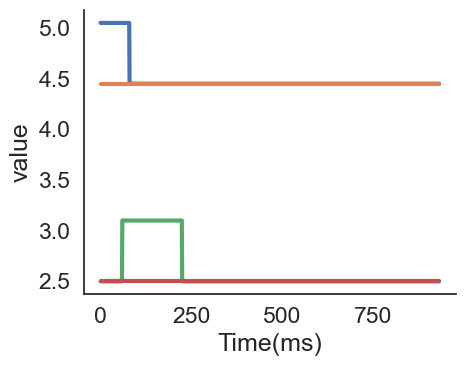

In [21]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.set(style="white", font_scale=1.5)
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['stop_input'],hue='nuclei',lw=3.0,ax=ax)
ax.legend_.remove()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.tight_layout()
#fig.savefig(figure_dir+'stop_input.png')

Extract the data tables from the agent:

In [ ]:
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]

Save the selected variables of results in the data_dir previously specified:

In [ ]:
cbgt.saveResults(results,data_dir+'network_data_'+str(seed)+'.pickle',['popfreqs','popdata','datatables'])

Plot the firing rates extracted (figure handles are returned in fig_handles).
Figure is saved in the figure_dir previously specified:

In [ ]:
FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
FR_fig_handles[0].savefig(figure_dir+"Example_FR_stopsignal.png",dpi=300)